# Segmentation of Figure 8

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import io, color, filters, measure, morphology, segmentation
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output
import warnings
warnings.filterwarnings('ignore')

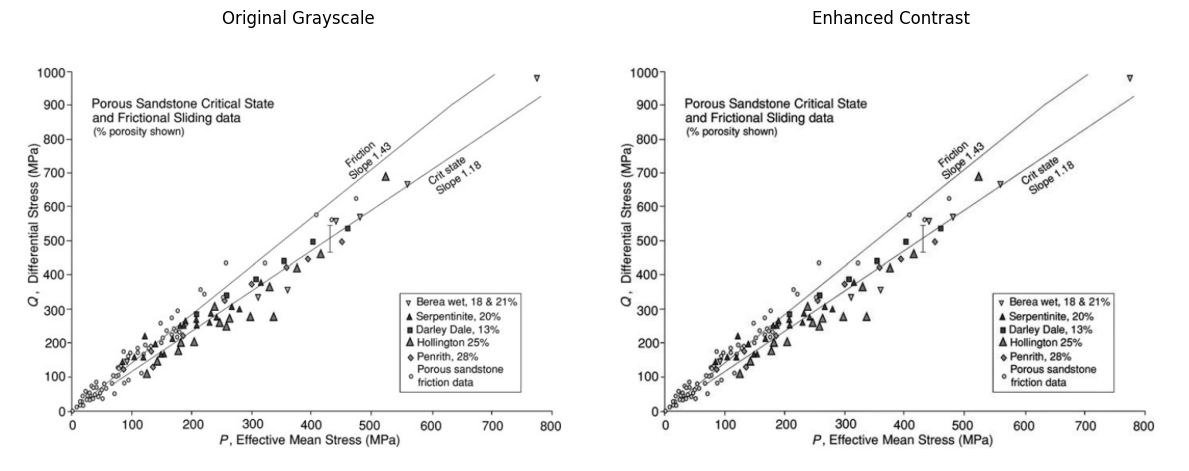

In [2]:
# Load Figure 8 graph
image = cv2.imread('figure/fig8.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
enhanced_grayscale = clahe.apply(grayscale_image)

# Display original and enhanced images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(grayscale_image, cmap='gray')
ax1.set_title('Original Grayscale')
ax1.axis('off')

ax2.imshow(enhanced_grayscale, cmap='gray')
ax2.set_title('Enhanced Contrast')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Use the enhanced image for further processing
grayscale_image = enhanced_grayscale

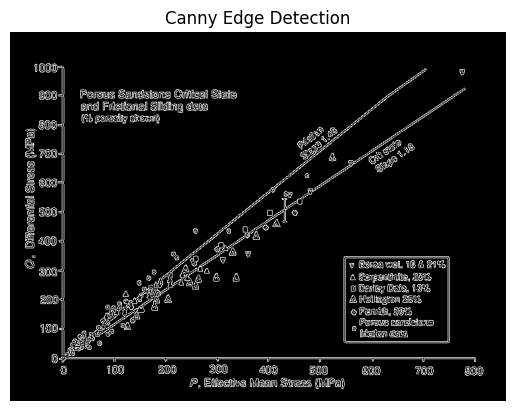

In [3]:
# Edge detection using Canny method
edges = cv2.Canny(grayscale_image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

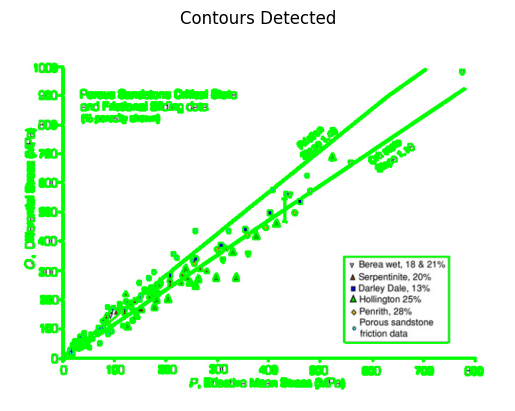

In [4]:
# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours on the original image
contour_image = image.copy()
for contour in contours:
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
plt.imshow(contour_image)
plt.title('Contours Detected')
plt.axis('off')
plt.show()

In [5]:
# Calculate areas of all contours
areas = [cv2.contourArea(c) for c in contours]
# print the areas of the contours
print(f"Number of contours: {len(areas)}")
print(f"Min area: {min(areas) if areas else 0}")
print(f"Max area: {max(areas) if areas else 0}")
print(f"Mean area: {np.mean(areas) if areas else 0}")
print(f"Median area: {np.median(areas) if areas else 0}")

Number of contours: 300
Min area: 0.0
Max area: 20663.5
Mean area: 108.54666666666667
Median area: 11.5


In [6]:
# Pair each contour with its area
contour_area_pairs = list(zip(contours, areas))
# Sort by area, descending
contour_area_pairs.sort(key=lambda x: x[1], reverse=True)

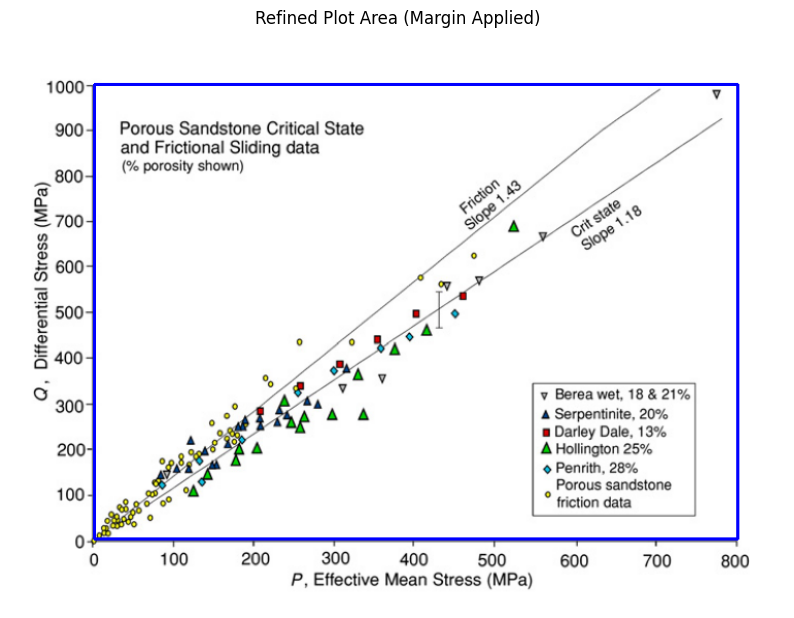

In [7]:
# Identifying the Plot Area
# Use Canny edge detection
edges = cv2.Canny(grayscale_image, 50, 150)

margin = 15  

# Use Hough Line Transform to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Find the extreme lines (leftmost, rightmost, topmost, bottommost)
x_min, x_max, y_min, y_max = image.shape[1], 0, image.shape[0], 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_min = min(x_min, x1, x2)
    x_max = max(x_max, x1, x2)
    y_min = min(y_min, y1, y2)
    y_max = max(y_max, y1, y2)

# Refine the bounding box
plot_left   = min(x_min + margin + 3, image.shape[1] - 1)
plot_right  = max(x_max, 0)
plot_top    = min(y_min, image.shape[0] - 1)
plot_bottom = max(y_max - margin - 30, 0)

# Ensure coordinates are within image bounds
plot_left   = max(plot_left, 0)
plot_right  = min(plot_right, image.shape[1] - 1)
plot_top    = max(plot_top, 0)
plot_bottom = min(plot_bottom, image.shape[0] - 1)

# Draw the refined plot area
plot_area_img = image.copy()
cv2.rectangle(plot_area_img, (plot_left, plot_top), (plot_right, plot_bottom), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_area_img, cv2.COLOR_BGR2RGB))
plt.title('Refined Plot Area (Margin Applied)')
plt.axis('off')
plt.show()

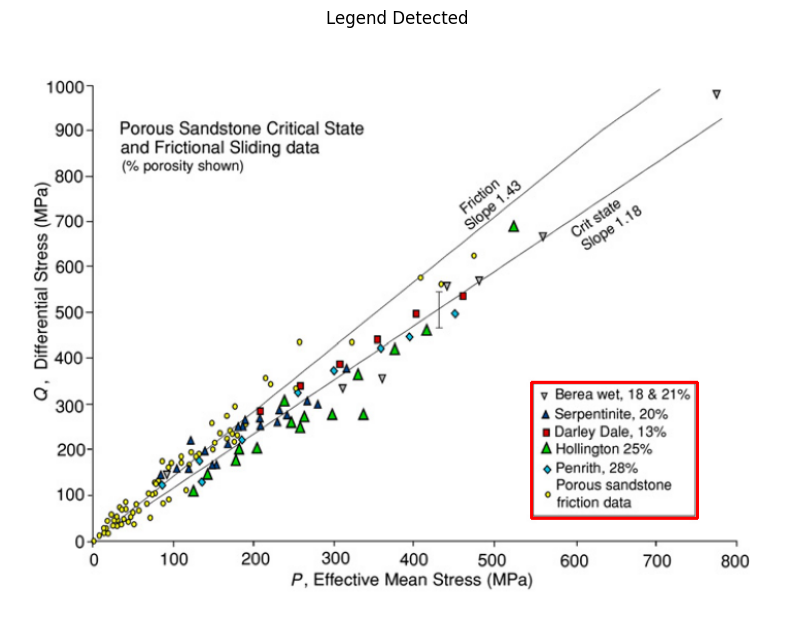

In [8]:
# Identifying the Legend Area
legend_candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0
    # Heuristic: legend is in the right 1/3 and lower 1/2 of the image, and is a medium-large box
    if (x > image.shape[1] * 0.6 and y > image.shape[0] * 0.5 and
        area > 1000 and area < 0.2 * image.shape[0] * image.shape[1] and
        0.7 < aspect_ratio < 2.5):
        legend_candidates.append((x, y, w, h))

# Draw the legend box
legend_img = image.copy()
for (x, y, w, h) in legend_candidates:
    cv2.rectangle(legend_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
plt.title('Legend Detected')
plt.axis('off')
plt.show()

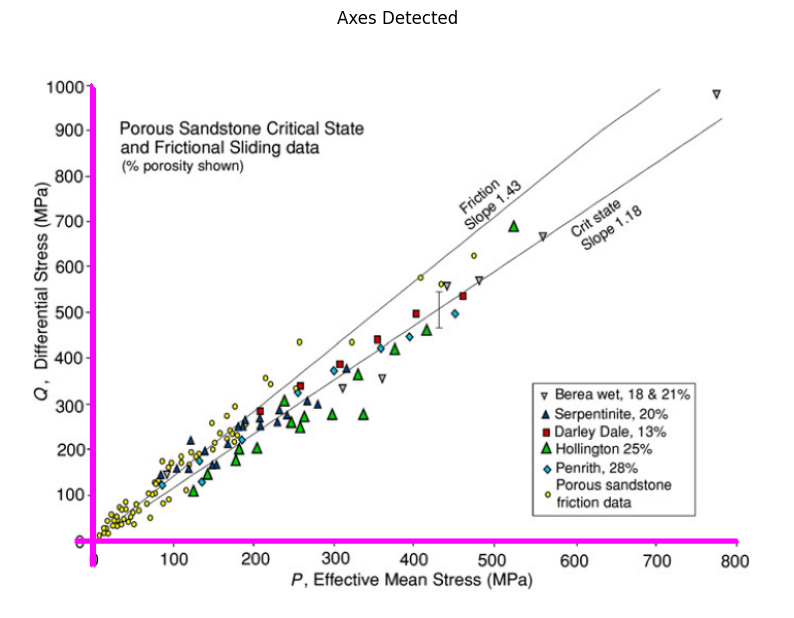

In [9]:
# Identifying the Axes Lines
axes_img = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Vertical (y-axis)
    if abs(x1 - x2) < 10 and abs(y1 - y2) > image.shape[0] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)
    # Horizontal (x-axis)
    if abs(y1 - y2) < 10 and abs(x1 - x2) > image.shape[1] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(axes_img, cv2.COLOR_BGR2RGB))
plt.title('Axes Detected')
plt.axis('off')
plt.show()

## Extract Text from Plot Regions
Extract text from title, legend, and axes scales & labels using OCR

## Extract Axes Information
Extract scales and titles from the detected axes regions

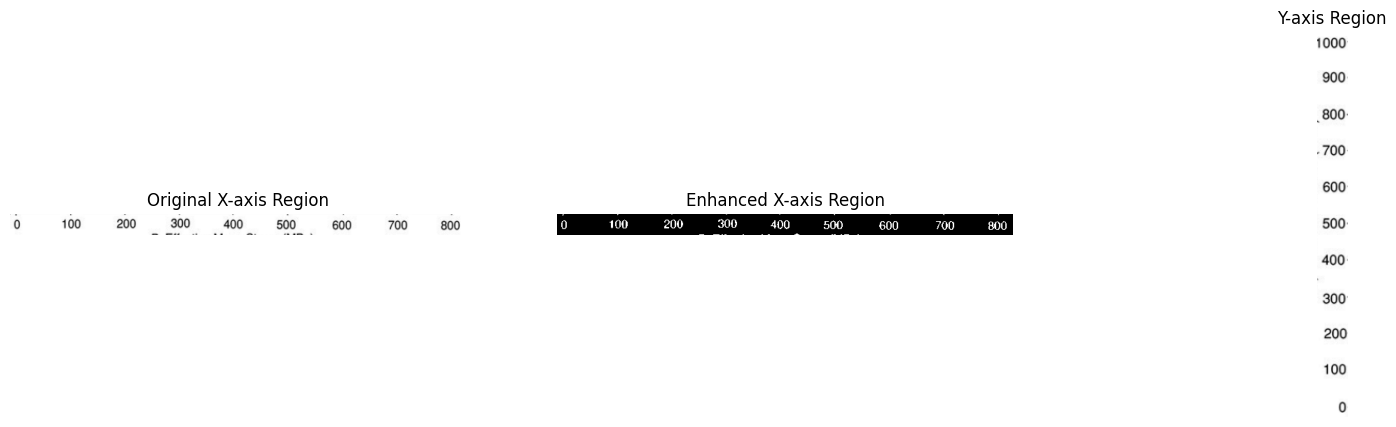

In [10]:
# Extract x-axis scale region with adjusted boundaries
x_scale_region = grayscale_image[plot_bottom+5:plot_bottom+35, plot_left-10:plot_right+20]

# Enhance x-axis scale visibility
x_scale_enhanced = cv2.threshold(
    x_scale_region,
    127, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)[1]

# Dilate text slightly to separate digits
kernel = np.ones((2,1), np.uint8)
x_scale_enhanced = cv2.erode(x_scale_enhanced, kernel, iterations=1)

# Extract y-axis scale region with adjusted boundaries
y_scale_region = grayscale_image[plot_top-10:plot_bottom+15, max(0, plot_left-44):plot_left-7]

# Visualize the extracted and preprocessed regions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(x_scale_region, cmap='gray')
ax1.set_title('Original X-axis Region')
ax1.axis('off')

ax2.imshow(x_scale_enhanced, cmap='gray')
ax2.set_title('Enhanced X-axis Region')
ax2.axis('off')

ax3.imshow(y_scale_region, cmap='gray')
ax3.set_title('Y-axis Region')
ax3.axis('off')
plt.show()

In [11]:
def process_x_axis_text(text):
    # Clean up the text
    text = text.replace('\n', ' ').strip()

    # If we have a long string of digits, try to segment it
    if len(text) > 10 and text.isdigit():
        # Try to segment based on expected values (0,100,200,300,etc)
        expected_values = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        values = []

        # Try different segmentation approaches
        for segment_length in [1, 2, 3, 4]:
            potential_values = []
            for i in range(0, len(text), segment_length):
                if i + segment_length <= len(text):
                    segment = text[i:i+segment_length]
                    try:
                        value = int(segment)
                        potential_values.append(value)
                    except ValueError:
                        continue

            # Check if this segmentation gives expected values
            if any(expected in potential_values for expected in expected_values):
                values = potential_values
                break

        return sorted(list(set(values)))

    # Original approach as fallback
    import re
    numbers = re.findall(r'\d+', text)
    values = []
    expected_values = [0, 100, 200, 300, 400, 500, 600, 700, 800]

    for num in numbers:
        try:
            value = int(num)
            if any(abs(value - expected) < 50 for expected in expected_values):
                values.append(value)
        except ValueError:
            continue

    return sorted(list(set(values)))

# Extract text from scale regions with specific OCR configuration
x_scale_text = pytesseract.image_to_string(
    x_scale_enhanced,  # Use the enhanced image
    config='--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789 -c tessedit_char_blacklist=.,- -c preserve_interword_spaces=1'
)

y_scale_text = pytesseract.image_to_string(
    y_scale_region,
    config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789.-'
)

# Process the text to extract values
x_values = process_x_axis_text(x_scale_text)
y_values = sorted([int(n) for n in y_scale_text.split() if n.strip()], reverse=True)

print('X-axis values:', x_values)
print('Y-axis values:', y_values)

X-axis values: [0, 100, 200, 300, 400, 500, 600, 700, 800]
Y-axis values: [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]


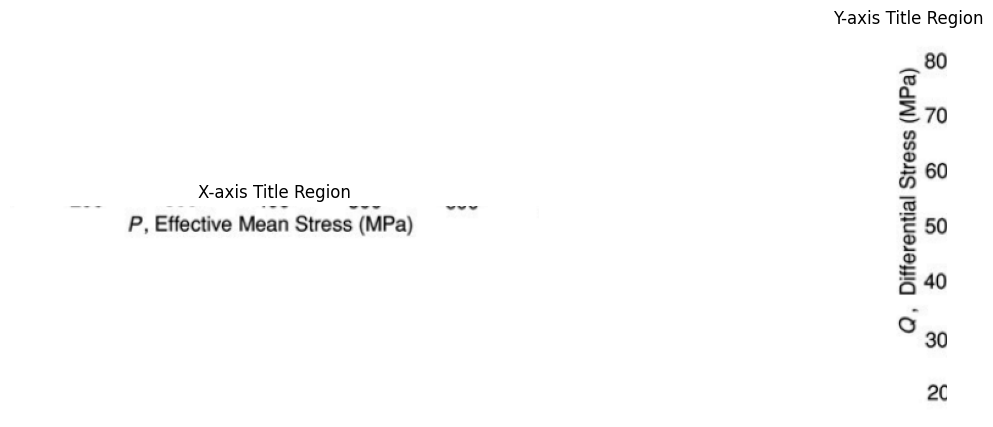

X-axis title: ___ P, Effective Mean Stress (MPa)
Y-axis title: ~ s Citororal Skoss wre)


In [12]:
# Extract a more precise region for the x-axis title
# The title appears to be centered below the x-axis scale
x_center = (plot_left + plot_right) // 2
x_title_width = int((plot_right - plot_left) * 0.7)  # Take 70% of plot width
x_title_region = grayscale_image[plot_bottom+25:plot_bottom+55,
                                x_center - x_title_width//2:x_center + x_title_width//2]

# For y-axis title, extract a taller, narrower region
# The title appears to be centered to the left of the y-axis scale
y_center = (plot_top + plot_bottom) // 2
y_title_height = int((plot_bottom - plot_top) * 0.7)  # Take 70% of plot height
y_title_region = grayscale_image[y_center - y_title_height//2:y_center + y_title_height//2,
                                max(0, plot_left-80):max(0, plot_left-20)]

# Visualize the extracted regions to verify they capture the titles correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(x_title_region, cmap='gray')
ax1.set_title('X-axis Title Region')
ax1.axis('off')

ax2.imshow(y_title_region, cmap='gray')
ax2.set_title('Y-axis Title Region')
ax2.axis('off')
plt.show()

# Apply simple preprocessing
x_title_enhanced = cv2.threshold(x_title_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
y_title_enhanced = cv2.threshold(y_title_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# OCR with appropriate configuration
x_title = pytesseract.image_to_string(
    x_title_enhanced,
    config='--psm 7 -l eng'  # Single line of text
).strip()

# For y-axis, rotate the image 90 degrees clockwise
y_title_rotated = cv2.rotate(y_title_enhanced, cv2.ROTATE_90_CLOCKWISE)
y_title = pytesseract.image_to_string(
    y_title_rotated,
    config='--psm 7 -l eng'  # Single line of text
).strip()

print('X-axis title:', x_title)
print('Y-axis title:', y_title)

In [13]:
# X-axis title region is good, just needs minor adjustment
x_title_region = grayscale_image[plot_bottom+25:plot_bottom+55,
                                x_center - x_title_width//2:x_center + x_title_width//2]

# For y-axis, try a different approach - extract a wider region
y_title_region = grayscale_image[y_center - y_title_height//2:y_center + y_title_height//2,
                                max(0, plot_left-100):plot_left]

# Apply better preprocessing for y-axis
# 1. Resize to larger dimensions
y_title_large = cv2.resize(y_title_region, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

# 2. Apply adaptive thresholding
y_title_enhanced = cv2.adaptiveThreshold(
    y_title_large, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2)

# OCR for x-axis (already working well)
x_title = pytesseract.image_to_string(
    x_title_enhanced,
    config='--psm 7 -l eng'
).strip().replace('___', '').strip()

# Extract y-axis title region
y_title_region = grayscale_image[plot_top:plot_bottom, max(0, plot_left-120):max(0, plot_left-10)]

# Basic preprocessing - resize and binarize
y_title_large = cv2.resize(y_title_region, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
_, y_title_binary = cv2.threshold(y_title_large, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Rotate and apply OCR with the optimal configuration
y_title_rotated = cv2.rotate(y_title_binary, cv2.ROTATE_90_CLOCKWISE)
y_title = pytesseract.image_to_string(
    y_title_rotated,
    config='--psm 11 --oem 3 -l eng'
).strip()

# If we get multiple lines, take just the first line (the title)
y_title = y_title.split('\n')[0] if '\n' in y_title else y_title

print('X-axis title:', x_title)
print('Y-axis title:', y_title)

X-axis title: P, Effective Mean Stress (MPa)
Y-axis title: Q, Differential Stress (MPa)


## Plot title extraction

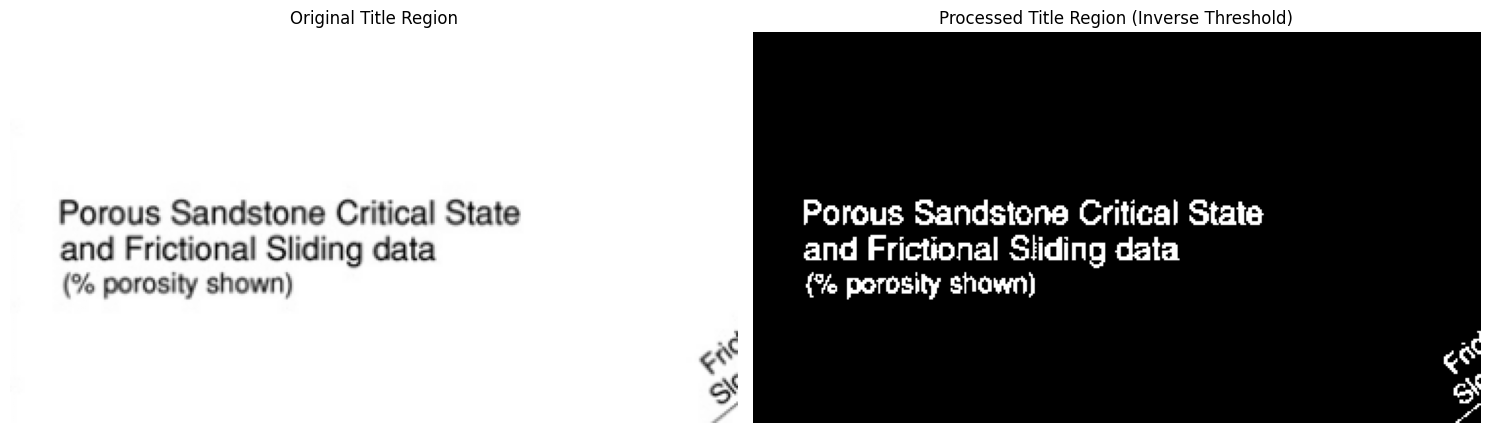

Plot title:
Porous Sandstone Critical State
and Frictional Sliding data
(% porosity shawn)


In [14]:
# Convert to grayscale if needed
if len(image.shape) == 3:
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    grayscale_image = image

# Focus on the top-left region with appropriate dimensions for this multi-line title
top_left_region = grayscale_image[max(0, plot_top-50):plot_top+150,
                                 plot_left:plot_left+int((plot_right-plot_left)*0.6)]

# Apply inverse thresholding (which worked best)
_, binary_inverse = cv2.threshold(top_left_region, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Visualize the region and preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(top_left_region, cmap='gray')
ax1.set_title('Original Title Region')
ax1.axis('off')

ax2.imshow(binary_inverse, cmap='gray')
ax2.set_title('Processed Title Region (Inverse Threshold)')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Extract text using OCR with PSM 3 (which worked best for multi-line text)
plot_title = pytesseract.image_to_string(
    binary_inverse,
    config='--psm 3 -l eng'
).strip()

# Clean up any remaining artifacts
plot_title = plot_title.replace('«', '').replace('ss', '').strip()

print('Plot title:')
print(plot_title)

## Extracting Data Points

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

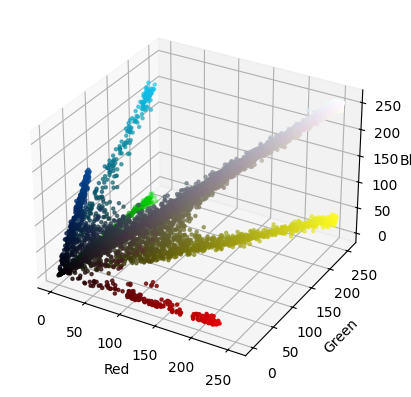

In [16]:
# RGB 3D color space visualization
r, g, b = cv2.split(image_rgb)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = image_rgb.reshape((np.shape(image_rgb)[0]*np.shape(image_rgb)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

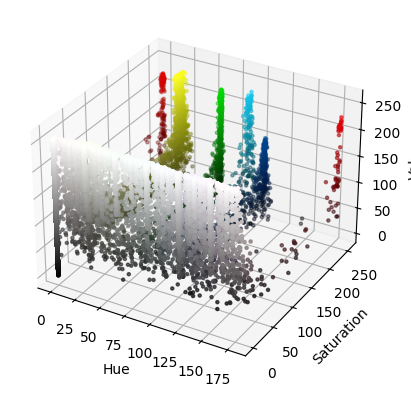

In [17]:
# HSV 3D color space visualization
hsv_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Dominant HSV values (cluster centers):
Cluster 1: H=33, S=231, V=130
Cluster 2: H=119, S=57, V=64
Cluster 3: H=29, S=161, V=82
Cluster 4: H=77, S=237, V=58
Cluster 5: H=96, S=150, V=47
Cluster 6: H=31, S=62, V=86
Cluster 7: H=116, S=246, V=128
Cluster 8: H=44, S=237, V=210


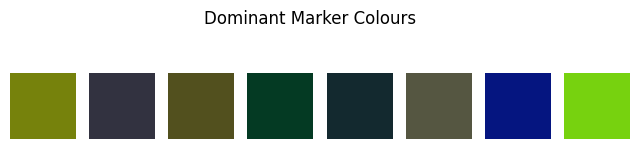

In [18]:

from sklearn.cluster import KMeans

# Mask out white/near-white background (tune thresholds as needed)
lower_bg = np.array([0, 0, 0])
upper_bg = np.array([180, 30, 255])
bg_mask = cv2.inRange(hsv_image, lower_bg, upper_bg)
fg_mask = cv2.bitwise_not(bg_mask)

# Extract foreground (marker) pixels
hsv_pixels = hsv_image[fg_mask > 0]
hsv_pixels = hsv_pixels.reshape(-1, 3)

# K-means clustering
n_clusters = 8  # Number of sandstones/marker colours
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(hsv_pixels)
centers = kmeans.cluster_centers_.astype(int)

print("Dominant HSV values (cluster centers):")
for i, center in enumerate(centers):
    print(f"Cluster {i+1}: H={center[0]}, S={center[1]}, V={center[2]}")

# Optional: Visualize cluster colors
cluster_rgbs = [cv2.cvtColor(np.uint8([[center]]), cv2.COLOR_HSV2RGB)[0,0] for center in centers]
plt.figure(figsize=(8,2))
for i, rgb in enumerate(cluster_rgbs):
    plt.subplot(1, n_clusters, i+1)
    plt.imshow([[rgb]])
    plt.axis('off')
plt.suptitle('Dominant Marker Colours')
plt.show()

In [ ]:

# Manually define the legend region (adjust these values for your image)
# Example: legend is on the right 20% of the image
h, w = image.shape[:2]
legend_crop = hsv_image[:, int(w*0.8):, :]  # Adjust as needed

# Convert to RGB for visualization
legend_rgb = cv2.cvtColor(legend_crop, cv2.COLOR_HSV2RGB)
plt.imshow(legend_rgb)
plt.title('Legend Area - Click on each swatch')
points = plt.ginput(n=6, timeout=0)  # Click on each legend swatch, then close
plt.close()

# Extract HSV values at clicked points
for i, (x, y) in enumerate(points):
    x, y = int(x), int(y)
    hsv = legend_crop[y, x]
    print(f"Legend swatch {i+1}: HSV={hsv}")

# You can now use these HSV values as the center of your mask ranges

Berea wet, 18 & 21%: 13 points detected.
Serpentinite, 20%: 12 points detected.
Darley Dale, 13%: 4 points detected.
Hollington, 25%: 5 points detected.
Penrith, 28%: 0 points detected.
Porous sandstone friction data: 0 points detected.


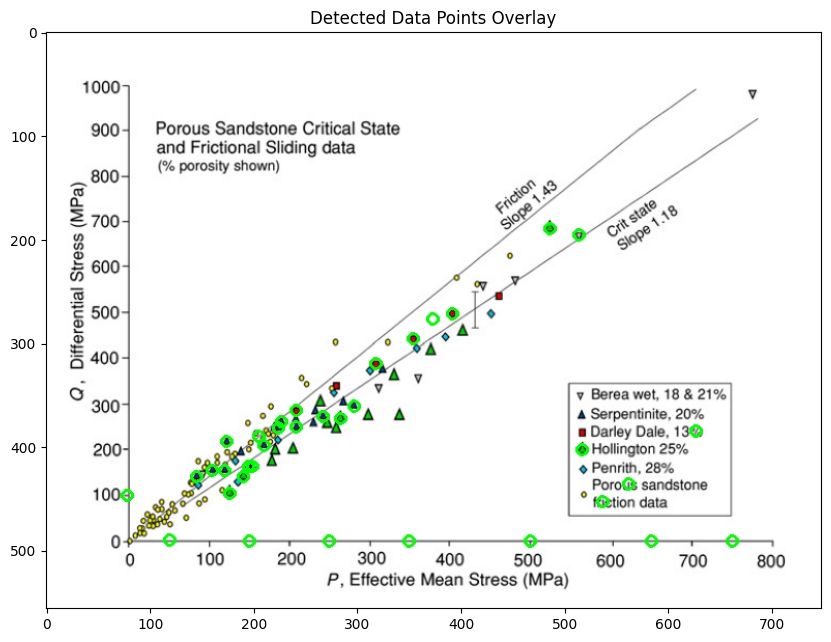

In [ ]:
# Define HSV ranges for each sandstone (expand as needed)
sandstone_hsv_ranges = {
   "Berea wet, 18 & 21%": ([0, 0, 100], [180, 50, 200]),
    "Serpentinite, 20%": ([100, 210, 60], [110, 255, 150]),
    "Darley Dale, 13%": ([0, 240, 200], [180, 255, 225]),
    "Hollington, 25%": ([55, 240, 180], [65, 255, 220]),
    "Penrith, 28%": ([90, 220, 190], [100, 250, 240]),
    "Porous sandstone friction data": ([25, 210, 140], [35, 240, 240])
}

# Manually set axis calibration (pixel and data coordinates)
# Example: (You must update these with your actual axis pixel and data values)
# These are the pixel coordinates of (xmin, ymin) and (xmax, ymax) on the image
x0, y0 = 100, 500  # pixel of (xmin, ymin)
x1, y1 = 600, 100  # pixel of (xmax, ymax)
xmin, xmax = 0, 10  # data axis limits (x)
ymin, ymax = 0, 1   # data axis limits (y)

def pixel_to_data(px, py):
    # Linear mapping from pixel to data coordinates
    data_x = xmin + (px - x0) * (xmax - xmin) / (x1 - x0)
    data_y = ymin + (y0 - py) * (ymax - ymin) / (y0 - y1)
    return data_x, data_y

# Store results for export
all_points = []

# Process each sandstone
for name, (lower, upper) in sandstone_hsv_ranges.items():
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(hsv_image, lower, upper)

    # Optional: Morphological operations to clean up mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours (data points)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            data_x, data_y = pixel_to_data(cx, cy)
            all_points.append([name, cx, cy, data_x, data_y])
            # Optionally, draw on image for validation
            cv2.circle(image, (cx, cy), 5, (0,255,0), 2)

    print(f"{name}: {len(contours)} points detected.")

# Show validation overlay
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Data Points Overlay")
plt.show()

# Export to CSV
# with open('sandstone_data_points.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Sandstone', 'Pixel_X', 'Pixel_Y', 'Data_X', 'Data_Y'])
#     writer.writerows(all_points)

# print("Data points exported to sandstone_data_points.csv")

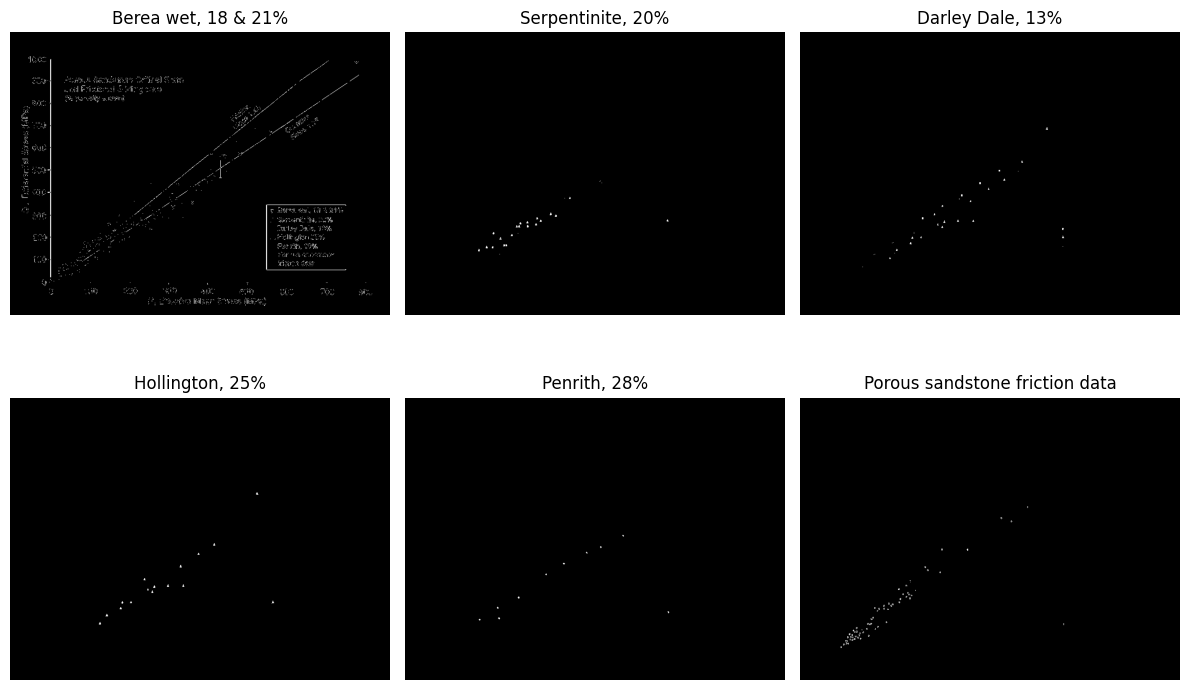

In [ ]:
plt.figure(figsize=(12, 8))
for i, (name, (lower, upper)) in enumerate(sandstone_hsv_ranges.items()):
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(hsv_image, lower, upper)
    plt.subplot(2, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

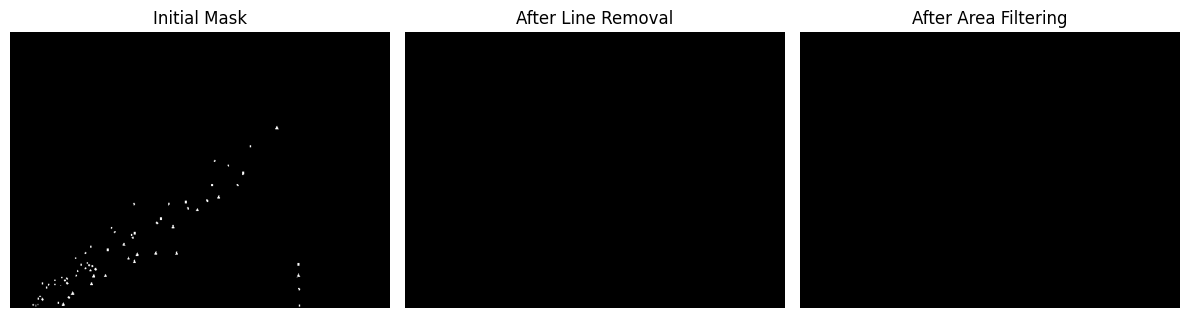

Extracted data points (image coordinates):
[]


In [ ]:



# 2. Crop to plot area (manually set these values for your image)
# Example: crop to [ymin:ymax, xmin:xmax]
crop_ymin, crop_ymax = 50, 450
crop_xmin, crop_xmax = 100, 650
img_cropped = hsv_image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]

# 3. Define HSV ranges for a sandstone (example for Darley Dale, adjust as needed)
lower = np.array([0, 200, 180], dtype=np.uint8)
upper = np.array([180, 255, 255], dtype=np.uint8)
mask = cv2.inRange(img_cropped, lower, upper)

# 4. Morphological filtering to remove thin lines (axes/grid)
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))  # horizontal
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))  # vertical
mask_no_h = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_h)
mask_no_lines = cv2.morphologyEx(mask_no_h, cv2.MORPH_OPEN, kernel_v)

# 5. Area filtering to keep only data points
contours, _ = cv2.findContours(mask_no_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_mask = np.zeros_like(mask)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 10 < area < 200:  # adjust for your marker size
        cv2.drawContours(filtered_mask, [cnt], -1, 255, -1)

# 6. Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask_no_lines, cmap='gray')
plt.title('After Line Removal')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(filtered_mask, cmap='gray')
plt.title('After Area Filtering')
plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Extract data point coordinates (in cropped image coordinates)
data_points = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 10 < area < 200:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            # Convert to original image coordinates
            orig_cx = cx + crop_xmin
            orig_cy = cy + crop_ymin
            data_points.append((orig_cx, orig_cy))

print("Extracted data points (image coordinates):")
print(data_points)

Detected data points (pixel coordinates and shape):


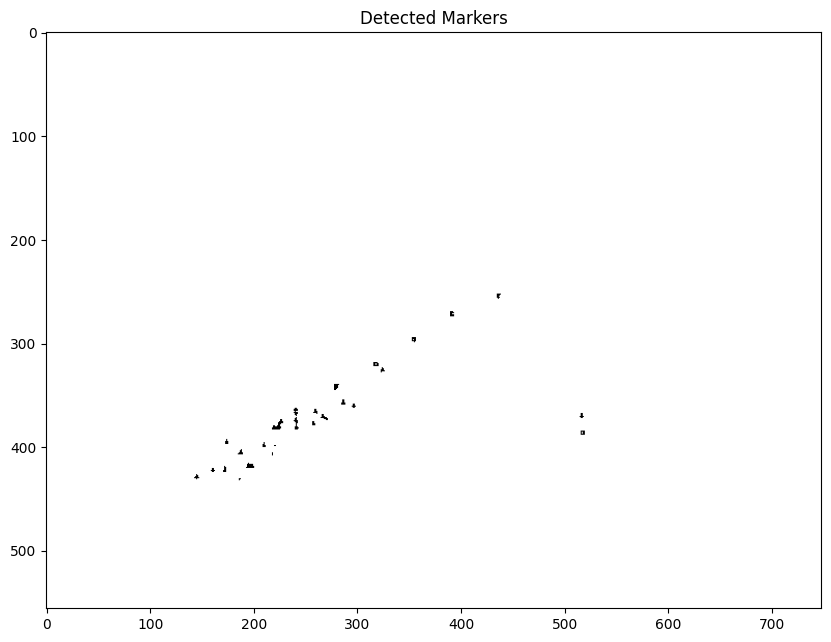

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img = cv2.imread('fig8.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
thresh = cv2.threshold(edges, 60, 255, cv2.THRESH_BINARY)[1]

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# For visualization
output = thresh.copy()

print("Detected data points (pixel coordinates and shape):")
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 30 or area > 1000:  # Adjust as needed for your marker size
        continue
    approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
    shape = None
    if len(approx) == 3:
        shape = "triangle"
    elif len(approx) == 4:
        # Could be square or diamond; further checks can be added
        shape = "square/diamond"
    elif len(approx) > 4:
        shape = "circle"
    else:
        continue

    # Calculate centroid
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        print(f"({cx}, {cy}) - {shape}")
        # Draw detected marker for visualization
        cv2.drawContours(output, [cnt], -1, (0,255,0), 2)
        cv2.circle(output, (cx, cy), 3, (0,0,255), -1)

# Show the result
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Detected Markers")
plt.show()